In [4]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from pickle import dump, load
import os
# from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

# Última camada sem função de ativação --> crossentropy já aplica softmax
# ReLU em intermediárias
    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = F.relu(layer(x))
        x = (self.linears[-1](x))
        return(x)

# # Aplicando função de ativação na última camada tbm
# ### Tentar mudar pra sigmoide se deixar a normalização de 0,1
#     def forward(self, x):
#         for layer in self.linears:                   
#             x = torch.sigmoid(layer(x))
# #             x = F.relu(layer(x))
#         return(x)

In [6]:
# Read xlsx with nets info
df_nets = pd.read_excel('D:/classification_nets_hpc_1.xlsx', index_col=None, header=0)
df_nets

,Net,random_state,num_layers,layers_size,net_param,criterion,learning_rate,optimizer,epochs,vali_best_epoch,...,vali_sur_loss,vali_sur_R,vali_c_matrix,vali_c_matrix_perc,test_acc,test_loss,test_R,test_predicted,test_c_matrix,test_c_matrix_perc
0,0,383,4,"[14, 3, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.070,Adam,50000,10300,...,41.574772,-0.068925,[[1 7 0 0]\n [1 4 1 1]\n [0 3 2 0]\n [1 6 1 1]],[[12.5 87.5 0. 0. ...,28,34.402950,0.412037,[0 1 1 1 1 1 2 1 1 1 1 1 1 1 0 2 1 3 1 1 0 2 1...,[[ 3 18 2 0]\n [ 3 10 2 0]\n [ 0 8 2 3]...,[[13.04347826 78.26086957 8.69565217 0. ...
1,1,4109,4,"[1, 4, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.074,Adam,50000,1000,...,9.731535,0.184996,[[ 1 2 0 0]\n [ 0 10 0 0]\n [ 0 9 0 0]...,[[ 33.33333333 66.66666667 0. 0. ...,22,5.084868,0.203060,[1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0...,[[ 3 20 0 0]\n [ 4 11 0 0]\n [ 0 13 0 0]...,[[ 13.04347826 86.95652174 0. 0. ...
2,2,8218,4,"[6, 21, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.014,Adam,50000,18500,...,79.517715,0.354087,[[1 4 3 0]\n [3 7 4 0]\n [1 2 0 1]\n [0 1 1 1]],[[12.5 50. 37.5 0. ...,19,28.634821,0.261171,[3 1 2 0 1 2 2 3 1 3 0 0 1 3 2 3 1 3 1 3 3 0 0...,[[ 2 14 3 4]\n [ 4 5 4 2]\n [ 3 3 1 6]...,[[ 8.69565217 60.86956522 13.04347826 17.39130...
3,3,1809,4,"[16, 7, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.029,Adam,50000,600,...,8.710876,-0.028076,[[5 1 1 0]\n [1 4 1 0]\n [3 0 4 0]\n [1 2 4 2]],[[71.42857143 14.28571429 14.28571429 0. ...,23,15.371380,0.062017,[0 0 3 0 2 2 2 1 1 3 1 0 2 2 2 3 1 1 0 3 1 2 1...,[[ 5 2 13 3]\n [ 3 4 7 1]\n [ 3 3 5 2]...,[[21.73913043 8.69565217 56.52173913 13.04347...
4,4,3026,4,"[12, 8, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.081,Adam,50000,100,...,13.123807,0.015653,[[0 1 1 3]\n [0 2 1 2]\n [1 1 2 6]\n [0 1 1 7]],[[ 0. 20. 20. 60. ...,31,8.777267,0.204782,[0 2 3 0 0 3 2 1 2 3 1 1 2 1 2 3 1 2 0 3 3 3 0...,[[ 6 4 2 11]\n [ 5 2 5 3]\n [ 0 3 5 5]...,[[26.08695652 17.39130435 8.69565217 47.82608...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,1626,7832,4,"[2, 7, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.092,Adam,50000,300,...,54.633717,0.271976,[[2 0 1 1]\n [1 3 0 3]\n [2 0 1 4]\n [1 1 0 9]],[[50. 0. 25. 25. ...,31,6.029893,0.265096,[2 1 3 0 3 3 3 1 1 3 2 2 3 2 0 3 3 3 2 3 3 3 3...,[[ 2 5 4 12]\n [ 2 4 3 6]\n [ 0 1 4 8]...,[[ 8.69565217 21.73913043 17.39130435 52.17391...
1627,1627,1138,4,"[12, 20, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.033,Adam,50000,1300,...,46.741245,-0.150382,[[4 3 0 0]\n [3 2 2 5]\n [0 0 2 2]\n [2 2 1 1]],[[57.14285714 42.85714286 0. 0. ...,33,21.410332,0.285840,[1 0 3 0 1 0 2 0 1 2 0 0 1 0 0 3 0 3 0 3 0 3 0...,[[11 9 1 2]\n [ 6 5 2 2]\n [ 5 0 3 5]...,[[47.82608696 39.13043478 4.34782609 8.69565...
1628,1628,2954,4,"[19, 19, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.093,Adam,50000,100,...,25.620527,-0.185646,[[1 1 3 2]\n [2 2 3 3]\n [0 0 5 1]\n [0 1 2 3]],[[14.28571429 14.28571429 42.85714286 28.57142...,20,13.344254,0.112039,[2 2 3 0 0 0 2 3 2 2 1 2 1 3 2 3 3 1 1 2 2 3 0...,[[ 5 3 7 8]\n [ 2 2 8 3]\n [ 1 2 5 5]...,[[21.73913043 13.04347826 30.43478261 34.78260...
1629,1629,8807,4,"[16, 22, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.052,Adam,50000,500,...,48.302124,0.074551,[[4 1 2 1]\n [1 4 2 1]\n [0 2 5 0]\n [0 2 3 1]],[[50. 12.5 25. 12.5 ...,25,28.510571,0.047565,[1 0 2 0 2 0 3 1 2 2 1 0 2 1 0 3 1 1 0 3 3 3 2...,[[6 4 7 6]\n [4 1 6 4]\n [3 3 6 1]\n [0 5 4 3]],[[26.08695652 17.39130435 30.43478261 26.08695...


In [12]:
# Load dataset
X_test = np.load('X_test.npy')
y_test_class = np.load('y_test_class.npy')

all_predicted = np.empty([df_nets.shape[0], y_test_class.shape[0]])

for i in range(df_nets.shape[0]-1):
    netX = df_nets.iloc[i]
    net_number = netX['Net']
    number_str = str(net_number)
    zero_filled_number = number_str.zfill(6)
    # Transformando o dado de teste
    # load the scaler
    scaler_x = load(open('D:/Nets_hpc/'+zero_filled_number+'_scaler_x.pkl', 'rb'))
    X_test_scaled = scaler_x.transform(X_test)

    # Parâmetros da rede
    torch.manual_seed(1234)
    num_layers = netX['num_layers']
    # print('Number of layers: %d' % (num_layers))
    layers_size = np.fromstring(netX['layers_size'][1:-1], dtype=int, sep=',')
    # print('Layers sizes:', layers_size)

    net = Net(input_size=X_test.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=4)

    # Optmizer and loss function
    criterion = nn.CrossEntropyLoss()
    learning_rate = netX['learning_rate']
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

    # Load best model
    checkpoint = torch.load('D:/Nets_hpc/'+zero_filled_number+'_model_best.pth.tar')
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    # Avaliando a acurácia do modelo utilizando os dados de teste transformados
    inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
    targets = torch.autograd.Variable(torch.Tensor(y_test_class).long())

    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets.squeeze())
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(out.data, 1)       

    error_count = y_test_class.size - np.count_nonzero((targets.squeeze() == predicted) .numpy())
    acc = 100 * torch.sum(targets.squeeze() == predicted) /  y_test_class.size
    r = np.corrcoef(predicted.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]

    # print('Errors: %d; Accuracy: %d%%' % (error_count, acc))
    # print('Teste Loss: %.4f' % (loss.item()))
    # print('R-corrcoef: %s' % (str(r)))

    all_predicted[i,:] = predicted.numpy()

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWar

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWar

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWar

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWar

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\sit

D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWar

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to b

D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\anaconda3\envs\zika\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to

In [13]:
print(all_predicted.shape)
print(all_predicted)

(1631, 63)
[[0. 1. 1. ... 1. 3. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [3. 1. 2. ... 3. 3. 1.]
 ...
 [2. 2. 3. ... 2. 1. 2.]
 [1. 0. 2. ... 3. 3. 2.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
voteClassOut, count = mode(all_predicted, axis=0)
print(voteClassOut)
voteClassOut = voteClassOut.reshape(63,1)

[[1. 1. 3. 0. 1. 1. 2. 1. 1. 3. 1. 0. 1. 1. 1. 3. 1. 2. 1. 3. 1. 3. 1. 2.
  3. 1. 3. 1. 3. 1. 1. 2. 1. 0. 3. 2. 1. 1. 2. 1. 3. 1. 2. 1. 2. 3. 2. 3.
  3. 1. 1. 1. 1. 1. 3. 1. 1. 0. 3. 1. 3. 3. 1.]]


In [15]:
print(y_test_class.reshape(1, 63))

[[1 0 0 0 0 0 1 2 1 2 2 2 1 3 1 1 0 2 0 0 0 2 1 3 3 3 2 1 0 0 0 2 2 1 2 1
  0 1 0 0 0 0 3 0 2 0 0 3 1 0 0 3 2 1 3 3 1 1 0 2 3 3 3]]


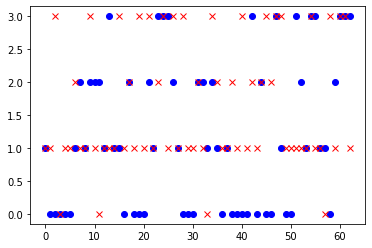

Acurácia 28.57142857142857 %


In [16]:
plt.figure()
plt.plot(y_test_class, 'ob')
plt.plot(voteClassOut, 'xr')
plt.show()
print('Acurácia', np.sum(y_test_class.squeeze()==voteClassOut.squeeze())/len(y_test_class)*100, '%')

In [17]:
# # Plot predicted vs target de uma rede
# ninput = np.arange(len(X_test))
# plt.figure()
# plt.plot(ninput, y_test_class, '-*', label = 'target')
# plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
# plt.title('Dados Normalizados')
# plt.legend()
# plt.show()